In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
# import pandas_profiling

import os
import os.path as osp
import gc
%matplotlib inline

In [2]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as py
import cufflinks as cf
cf.go_offline()
init_notebook_mode(connected=True)

pd.set_option('display.max_columns', 500)

In [3]:
flat_df = pd.read_csv('flat.csv', encoding='cp1251')
price_df = pd.read_csv('price.csv', encoding='cp1251')
status_df = pd.read_csv('status.csv', encoding='cp1251')
train_df = pd.read_csv('train.csv', encoding='cp1251')
test_df = pd.read_csv('test.csv')

In [4]:
from dateutil.relativedelta import relativedelta
from tqdm import tqdm_notebook

# deltas={}
# for set_id,set_group in tqdm_notebook(train_df[['id','date1','value','price']].groupby('id')):
#     set_group = set_group.drop('id', axis=1).set_index('date1')
#     delta = {date : set_group.loc[date] - set_group.loc[date+relativedelta(months=1)]
#             for date in set_group.index if date+relativedelta(months=1) in set_group.index}
#     deltas[set_id] = pd.DataFrame(delta).T

VALID = True
TEST_START_DATE = pd.to_datetime('2018-02-01')

In [5]:
train_df['id'] = train_df.bulk_id.astype(str)+'\\'+train_df.spalen.astype(str)
test_df['id'] = test_df.bulk_id.astype(str)+'\\'+test_df.spalen.astype(str)

In [6]:
df = pd.concat([train_df, test_df])[train_df.columns]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [7]:
# df['id'] = df.bulk_id.astype(str)+'\\'+df.spalen.astype(str)
df = df.merge(df.groupby('id')['month_cnt'].min().rename('month_sale_start').reset_index(),
               on='id', how='left')
df['months_after_start'] = df['month_cnt'] - df['month_sale_start']

In [8]:
df['date1'] = pd.to_datetime(df.date1)

In [9]:
import itertools 
TARGET_COLS  = ['plan_l','plan_m', 'plan_s', 'start_square', 'value',
 'vid_0', 'vid_1', 'vid_2']




In [10]:
# TODO: features from "future" for test part
def unroll_history(df, target_cols=TARGET_COLS, months_before = 3, months_forward = 3):

    out_df = []
    for _, set_df in tqdm_notebook(df.groupby('id')):
        min_date, max_date = set_df.date1.min(), set_df.date1.max()
        dates = [min_date+relativedelta(months=m) 
                 for m in itertools.takewhile(lambda m: min_date+relativedelta(months=m)<max_date, range(36))]
        train_dates = list(filter(lambda d: d < TEST_START_DATE, dates))

        set_df = set_df.set_index('date1').sort_index()
        nontarget_col = list(set(set_df.columns) - set(target_cols))

        unrolled_df =[]
        for date in (train_dates+[TEST_START_DATE]):
            data_df = []
            for m in range(months_forward):
                dt = date+relativedelta(months=m)
                if dt not in set_df.index:
                    continue
                row = set_df.loc[dt].copy()
                row['months_forward'] = m
                row['base_date'] = date
                row['date'] = dt
                data_df.append(row)

            past_targets = []
            for m in range(1,months_before+1):
                dt = date-relativedelta(months=m)
                if dt in set_df.index:
                    to_append = set_df.loc[dt][target_cols]
                else:
                    to_append = pd.Series(index=target_cols)
                to_append = to_append.rename(lambda s: s+'/'+ str(m)+'_months_before')
                past_targets.append(to_append)
            past_targets = pd.concat(past_targets, axis=0)
            if len(data_df) != 0:
                data_df = pd.concat([pd.concat([s,past_targets] )for s in data_df], axis=1).T
                data_df['date'] = pd.to_datetime(data_df['date'])
                data_df['base_date'] = pd.to_datetime(data_df['base_date'])
                unrolled_df.append(data_df)
        if len(unrolled_df)!= 0:
            out_df.append(pd.concat(unrolled_df))
    return pd.concat(out_df)
unrolled_df = unroll_history(df)

In [11]:
# def unroll_history(df, target_cols=TARGET_COLS, months_before = 3, months_forward = 3):
#     unrolled_set_df = []
#     for IDX, set_df in tqdm_notebook(df.groupby('id')):
#         set_df = set_df.set_index('date1').sort_index()
#         rolled_set_df = {}
#         rolled_target_df = {}
        
            
#         dates = set_df.index.sort_values().tolist()
#         no_past = len(dates) < months_forward
#         if no_past:
#             dates = [date-relativedelta(months=months_forward) for d in dates]
#         else:
#             dates = dates[:-(months_forward-1)]
#         for date in dates: 
# #                 target_df = pd.concat(
# #                     [set_df.loc[date+relativedelta(months=m)][target_cols].rename(lambda s: s+'/'+str(m)+'_months_forward')
# #                     for m in range(months_forward)], axis=0)
#             target_df = []
#             for m in range(months_forward):
#                 dt = date+relativedelta(months=m)
#                 if dt in set_df.index:
#                     to_append = set_df.loc[dt][target_cols]
#                 else:
#                     to_append = pd.Series(index=target_cols)
#                 to_append = to_append.rename(lambda s: s+'/'+ str(m)+'_months_forward')
#                 target_df.append(to_append)
#             target_df = pd.concat(target_df, axis=0)
            

#             past_targets = []
#             for m in range(1,months_before+1):
#                 dt = date-relativedelta(months=m)
#                 if dt in set_df.index:
#                     to_append = set_df.loc[dt][target_cols]
#                 else:
#                     to_append = pd.Series(index=target_cols)
#                 to_append = to_append.rename(lambda s: s+'/'+ str(m)+'_months_before')
#                 past_targets.append(to_append)
#             past_targets = pd.concat(past_targets, axis=0)

#             if no_past:
#                 other_feats= set_df.loc[set_df.index.min()][list(set(set_df.columns) - set(target_cols))]
#             else:
#                 other_feats = set_df.loc[date][list(set(set_df.columns) - set(target_cols))]
                
#             row = pd.concat([other_feats, past_targets])
#             rolled_set_df[date]=row
#             rolled_target_df[date]=target_df

#         unrolled_set_df.append(pd.concat([pd.DataFrame(rolled_set_df).T, pd.DataFrame(rolled_target_df).T], axis=1))

#     return pd.concat(unrolled_set_df)



In [159]:
import itertools

def make_consistent_fold(X, y, train_idx, test_idx):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    #remove samples from test set
    y_train = y_train.loc[y_train.dropna(axis=0).index]
    X_train = X_train.loc[y_train.index]
    
    y_test = y_test.loc[y_test.dropna(axis=0).index]
    X_test = X_test.loc[y_test.index]
    
    #remove future target leak
#     months_forward = X_test.months_forward.unique()
#     for forward in months_forward:
#         for backward in range(1,forward+1):
#             leak_columns = list(filter(lambda s: '{}_months_before'.format(backward) in s, X_test.columns))
#             X_test.loc[X_test.months_forward==forward,leak_columns] = np.nan
    
    return X_train, X_test, y_train, y_test

class WalkForwardFolds:
    def __init__(self,start_date,end_date):
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        
    def split(self,X,y=None, date_col = 'base_date'):
        dates = pd.to_datetime(X[date_col])
        masks, forward, date = [],0, self.start_date
        while(date < self.end_date):
            train_mask = dates <= date
            val_mask   = (dates > date) & (dates <= date+relativedelta(months=1)) 
            forward += 1
            date = self.start_date + relativedelta(months=forward)
            masks.append((train_mask, val_mask))
            
        for train_mask, val_mask in masks:
            yield np.arange(len(X))[train_mask], np.arange(len(X))[val_mask]

In [160]:
if VALID:
    wff = WalkForwardFolds(start_date='2017-01-01',end_date=TEST_START_DATE-relativedelta(months=3))
else:
    wff = WalkForwardFolds(start_date=TEST_START_DATE-relativedelta(months=1),end_date=TEST_START_DATE)

In [14]:
target_cols = TARGET_COLS
nontarget_cols = [c for c in unrolled_df.columns if c not in target_cols]

unrolled_df.reset_index(drop=True, inplace=True)
X,y = unrolled_df[nontarget_cols],unrolled_df[target_cols]

# Train LightGBM

In [15]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

In [152]:
categorical = ['Лифт', 'Кондиционирование', 'Огорожена территория',
       'Подземная парковка', 'ФОК', 'Кладовые', 'Система мусоротведения',
       'Автомойка', 'Двор без машин', 'Колясочные','Класс объекта',
       'Спортивная площадка', 'Входные группы','spalen']
to_drop = ['bulk_id','month','month_sale_start','month_cnt', 'id','base_date','date']
target_col = 'value'

def prepare_for_lgb(X_train, X_test, y_train, y_test=None):
    X_train = X_train.fillna(-1).drop(columns=to_drop)
    X_test = X_test.fillna(-1).drop(columns=to_drop)
    
    tmp = pd.concat([X_train, X_test])
    for col in categorical:
        le = LabelEncoder()
        le.fit(tmp[col])
        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
    
    y_train = y_train[target_col]
    if y_test is not None:
        y_test = y_test[target_col]
    return X_train, X_test, y_train, y_test

In [161]:
def rmse(preds, train_data):
    labels = train_data.get_label()
    return 'rmse', np.sqrt(np.mean((labels - preds)**2)), False

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}

MAX_LGB_ESTIMATORS = 1000
train_losses, val_losses = [], []

for train_idx, test_idx in wff.split(X):
    X_train, X_test, y_train, y_test = make_consistent_fold(X,y,train_idx, test_idx)
    X_tr, X_te, y_tr, y_te = prepare_for_lgb(X_train, X_test, y_train, y_test)
    lgb_train = lgb.Dataset(X_tr, y_tr, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_te, y_te, reference=lgb_train, free_raw_data=False) if y_te is not None else None

    gbm_history=dict()
    gbm = lgb.train(params,
                    lgb_train,
                    feval=rmse,
                    num_boost_round=MAX_LGB_ESTIMATORS,
                    valid_sets=[lgb_train, lgb_eval], 
                    categorical_feature=categorical,
                    callbacks =[lgb.record_evaluation(gbm_history)],
                   verbose_eval=200)
    
    train_losses.append(gbm_history['training']['rmse'])
    val_losses.append(gbm_history['valid_1']['rmse'])



/home/ubuntu/.local/lib/python3.6/site-packages/lightgbm/basic.py:1038: UserWarning:

categorical_feature in Dataset is overridden. New categorical_feature is ['spalen', 'Автомойка', 'Входные группы', 'Двор без машин', 'Кладовые', 'Класс объекта', 'Колясочные', 'Кондиционирование', 'Лифт', 'Огорожена территория', 'Подземная парковка', 'Система мусоротведения', 'Спортивная площадка', 'ФОК']

/home/ubuntu/.local/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning:

categorical_feature in param dict is overridden.



[200]	training's l2: 22172.3	training's rmse: 148.904	valid_1's l2: 49934.4	valid_1's rmse: 223.46
[400]	training's l2: 12774	training's rmse: 113.022	valid_1's l2: 43663.8	valid_1's rmse: 208.959
[600]	training's l2: 8486.79	training's rmse: 92.1238	valid_1's l2: 40290.7	valid_1's rmse: 200.726
[800]	training's l2: 5939.75	training's rmse: 77.0698	valid_1's l2: 38083.6	valid_1's rmse: 195.15
[1000]	training's l2: 4400.73	training's rmse: 66.338	valid_1's l2: 36652.8	valid_1's rmse: 191.449
[200]	training's l2: 23535.4	training's rmse: 153.413	valid_1's l2: 46459	valid_1's rmse: 215.544
[400]	training's l2: 13926.6	training's rmse: 118.011	valid_1's l2: 41667	valid_1's rmse: 204.125
[600]	training's l2: 9150.4	training's rmse: 95.6577	valid_1's l2: 40315.1	valid_1's rmse: 200.786
[800]	training's l2: 6598.17	training's rmse: 81.2291	valid_1's l2: 38831.8	valid_1's rmse: 197.058
[1000]	training's l2: 4868.54	training's rmse: 69.7749	valid_1's l2: 38277.1	valid_1's rmse: 195.645
[200]	tr

In [158]:
pd.DataFrame(train_losses).T

0           1           2           3           4           5  \
0    385.305009  384.323783  378.902584  371.370983  362.382193  354.827965   
1    375.755415  375.360897  369.826281  362.583139  353.958943  346.525084   
2    366.819850  366.772748  361.266701  354.363037  346.087543  338.654705   
3    358.426149  358.774117  353.240437  346.727363  338.770361  331.383654   
4    350.662577  351.472914  345.689999  339.541208  331.823474  324.367218   
5    343.164477  344.294000  338.721589  332.634561  325.447974  317.733936   
6    336.273463  337.922181  332.487914  326.278076  319.331941  311.672189   
7    329.830001  331.748774  326.417395  320.120024  313.635166  306.338425   
8    323.776237  326.303498  320.879638  314.480484  308.335365  301.192896   
9    318.088067  320.775410  315.735591  309.277860  303.350547  296.345115   
10   312.623436  315.722159  310.613321  304.295201  298.566956  291.827604   
11   307.833353  310.728498  305.824912  299.690254  294.014859  287.405020   
12   303.233537  306.272726  301.437366  295.451637  289.813588  283.229121   
13   298.517093  301.514861  297.091622  291.285128  285.882218  279.101462   
14   294.222970  297.533320  293.344851  287.462266  282.167227  275.344861   
15   290.215627  293.524210  289.317037  283.861598  278.364830  272.018556   
16   286.370433  289.888395  285.721966  280.538294  274.892621  268.767979   
17   282.859652  286.176602  282.297611  277.450371  271.595362  265.855922   
18   279.141215  282.849582  278.714065  274.440813  268.442322  262.871167   
19   275.662484  279.838645  275.733354  271.453955  265.489367  260.204779   
20   272.663153  276.540225  272.641656  268.630159  262.614828  257.541721   
21   269.778023  273.822656  269.891000  265.829082  259.917469  255.009968   
22   267.106467  270.971586  267.172431  263.089847  257.493203  252.715666   
23   264.555457  268.428060  264.300560  260.669400  254.971815  250.543077   
24   262.123375  266.180472  261.826751  258.304038  252.682317  248.304681   
25   259.577897  263.704900  259.252017  256.224601  250.602108  246.306424   
26   257.165317  261.532951  256.778944  253.947568  248.358270  244.206456   
27   254.626763  259.313236  254.752900  251.955993  246.006770  242.228453   
28   252.241524  257.514367  252.616680  250.146438  243.970862  240.231739   
29   250.087394  255.570550  250.580398  248.310050  241.971742  238.684590   
..          ...         ...         ...         ...         ...         ...   
970   67.669558   71.253284   71.605480   73.850503   74.225110   76.808037   
971   67.643503   71.210845   71.520382   73.807387   74.141134   76.754058   
972   67.587226   71.160121   71.464790   73.760944   74.083395   76.727175   
973   67.559468   71.131084   71.412482   73.731095   74.007353   76.691216   
974   67.497348   71.086102   71.349704   73.693038   73.960157   76.641061   
975   67.469720   71.040480   71.307880   73.634906   73.911800   76.601289   
976   67.437455   70.985785   71.256559   73.563625   73.871560   76.566895   
977   67.394844   70.937382   71.195722   73.514409   73.817534   76.536155   
978   67.368414   70.856691   71.156449   73.472442   73.747943   76.493414   
979   67.316998   70.794489   71.101098   73.422691   73.713792   76.432905   
980   67.254653   70.734390   71.043433   73.362457   73.673390   76.354823   
981   67.211830   70.689813   70.988006   73.330027   73.627900   76.306929   
982   67.154621   70.655235   70.936735   73.267136   73.554519   76.253297   
983   67.103199   70.604189   70.875014   73.179939   73.502230   76.201472   
984   67.064042   70.550947   70.819224   73.147892   73.450546   76.142024   
985   67.023252   70.484330   70.774291   73.113194   73.398543   76.109295   
986   66.986313   70.410728   70.729983   73.081506   73.351463   76.080953   
987   66.943908   70.345989   70.655577   73.055401   73.308398   76.044419   
988   66.885595   70.300155   70.611788   73.007551   73.261660 

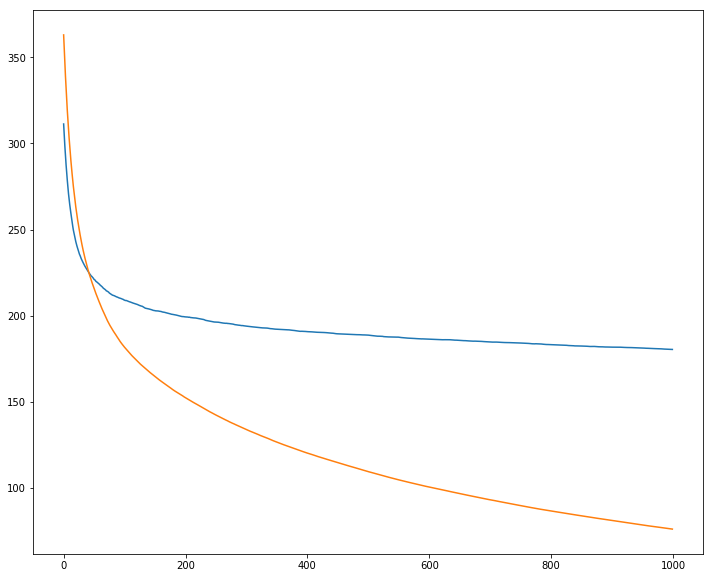

In [162]:
plt.figure(figsize=(12,10))
plt.plot(np.mean(val_losses, axis=0))
plt.plot(np.mean(train_losses, axis=0))

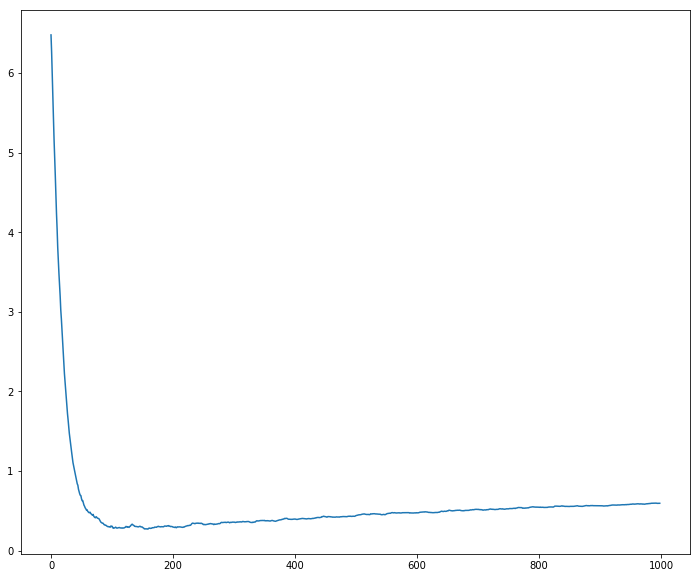

In [163]:
plt.figure(figsize=(12,10))
val_loss_improve = -pd.Series( np.diff(np.mean(val_losses, axis=0))).ewm(10).mean()
overfit = (np.mean(val_losses, axis=0) - np.mean(train_losses, axis=0))
plt.plot((overfit/np.mean(val_losses, axis=0))[:-1] + val_loss_improve)

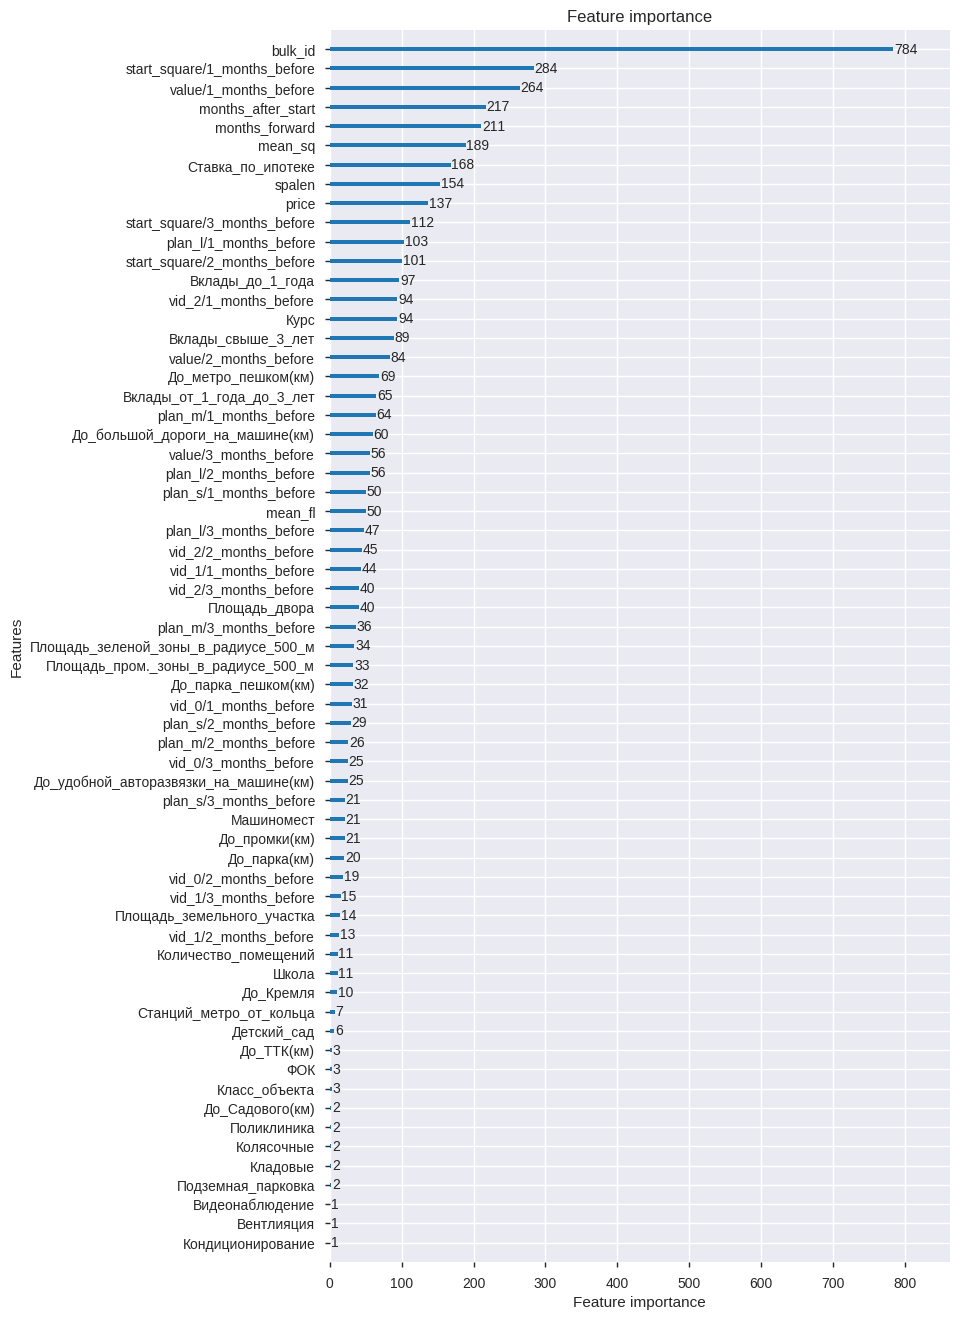

In [462]:
lgb.plot_importance(gbm, figsize=(8,16))

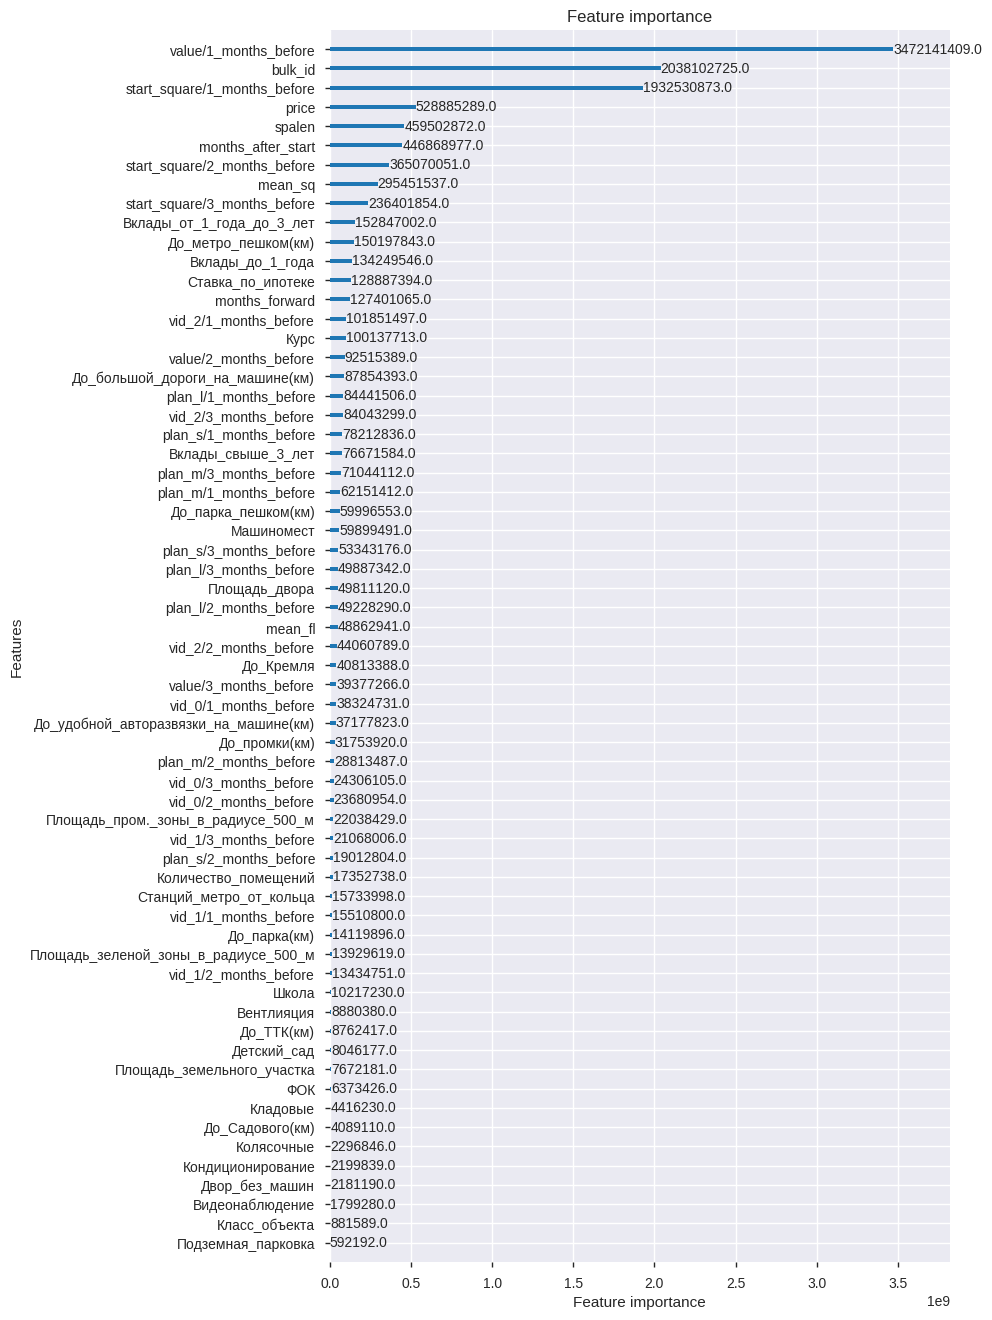

In [318]:
lgb.plot_importance(gbm, figsize=(8,12), importance_type='gain')

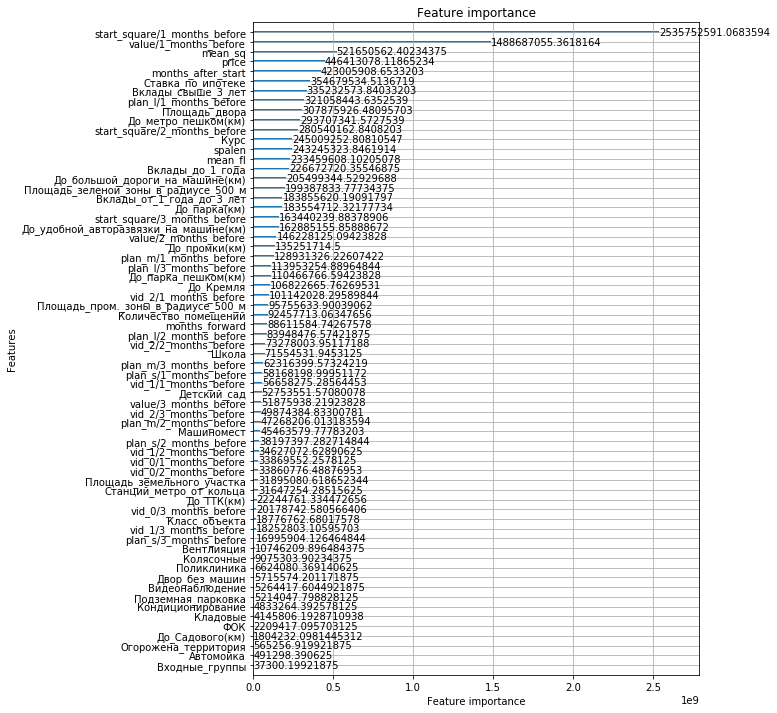

In [144]:
lgb.plot_importance(gbm, figsize=(8,12), importance_type='gain')

In [280]:
submis = X_test.copy()
submis['value']= gbm.predict(X_test.drop(columns=['bulk_id']))
for col in key_category:
    submis[col] = key_encoder[col].inverse_transform(submis[col])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [281]:
submis['months_forward'] = submis.months_forward.\
    apply(lambda m: (pd.to_datetime('2018-02-01')+relativedelta(months=m)).strftime("%Y-%m-%d"))

In [282]:
submis = test_df[['bulk_id', 'spalen', 'date1']].merge(submis[['bulk_id', 'spalen', 'months_forward','value']],
              left_on=['bulk_id', 'spalen', 'date1'],
                right_on = ['bulk_id', 'spalen', 'months_forward'], how='left')

In [283]:
submis['value'].reset_index().rename(columns={'index':'id'}).to_csv('baseline_without_bulk_id.csv',index=False)

In [287]:
submis['value'][submis['value']<0]

247   -4.108552
254   -1.009839
290   -1.920364
466   -0.629972
500   -1.714188
Name: value, dtype: float64

In [119]:
unrolled_df.base_date[0]

0   2017-06-01
0   2017-07-01
0   2017-08-01
0   2017-09-01
0   2017-10-01
0   2017-11-01
0   2017-12-01
0   2018-01-01
0   2018-02-01
0   2017-06-01
0   2017-07-01
0   2017-08-01
0   2017-09-01
0   2017-10-01
0   2017-11-01
0   2017-12-01
0   2018-01-01
0   2018-02-01
0   2016-10-01
0   2017-04-01
0   2017-05-01
0   2017-06-01
0   2017-07-01
0   2017-08-01
0   2017-09-01
0   2017-10-01
0   2017-11-01
0   2017-12-01
0   2018-01-01
0   2018-02-01
       ...    
0   2017-05-01
0   2017-06-01
0   2017-07-01
0   2017-08-01
0   2017-09-01
0   2017-10-01
0   2017-11-01
0   2017-12-01
0   2018-01-01
0   2018-02-01
0   2017-10-01
0   2017-11-01
0   2017-12-01
0   2018-01-01
0   2018-02-01
0   2017-10-01
0   2017-11-01
0   2017-12-01
0   2018-01-01
0   2018-02-01
0   2017-10-01
0   2017-11-01
0   2017-12-01
0   2018-01-01
0   2018-02-01
0   2017-10-01
0   2017-11-01
0   2017-12-01
0   2018-01-01
0   2018-02-01
Name: base_date, Length: 9642, dtype: datetime64[ns]

In [212]:
for tr, te in wff.split(unrolled_df):
    print(len(tr),' ',len(te))

25158   1770


In [151]:
unrolled_df.date - unrolled_df.base_date

0    0 days
1   30 days
2   61 days
0    0 days
1   31 days
2   62 days
0    0 days
1   31 days
2   61 days
0    0 days
1   30 days
2   61 days
0    0 days
1   31 days
2   61 days
0    0 days
1   30 days
2   61 days
0    0 days
1   31 days
2   62 days
0    0 days
1   31 days
0    0 days
0    0 days
1   30 days
2   61 days
0    0 days
1   31 days
2   62 days
      ...  
0    0 days
1   31 days
2   61 days
0    0 days
1   30 days
2   61 days
0    0 days
1   31 days
2   62 days
0    0 days
1   31 days
2   59 days
0    0 days
1   28 days
2   59 days
0    0 days
1   31 days
2   61 days
0    0 days
1   30 days
2   61 days
0    0 days
1   31 days
2   62 days
0    0 days
1   31 days
2   59 days
0    0 days
1   28 days
2   59 days
Length: 26928, dtype: timedelta64[ns]

In [70]:
!pip3 install -U --upgrade pandas


  Using cached https://files.pythonhosted.org/packages/1d/cb/1cc27b57855a7f7c25965ab257e2bf251589bfe450e2cb23820b11a674a6/pandas-0.23.3-cp35-cp35m-manylinux1_x86_64.whl
Requirement not upgraded as not directly required: python-dateutil>=2.5.0 in /usr/local/lib/python3.5/dist-packages (from pandas) (2.7.2)
Requirement not upgraded as not directly required: pytz>=2011k in /usr/local/lib/python3.5/dist-packages (from pandas) (2018.4)
Requirement not upgraded as not directly required: numpy>=1.9.0 in /usr/local/lib/python3.5/dist-packages (from pandas) (1.14.2)
Requirement not upgraded as not directly required: six>=1.5 in /usr/local/lib/python3.5/dist-packages (from python-dateutil>=2.5.0->pandas) (1.10.0)
botocore 1.10.4 has requirement python-dateutil<2.7.0,>=2.1, but you'll have python-dateutil 2.7.2 which is incompatible.
  Found existing installation: pandas 0.22.0
    Uninstalling pandas-0.22.0:

You are using pip version 10.0.0, however version 10.0.1 is available.
You should consi

In [ ]:
p